In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt

In [2]:
PATH = './'
TRAIN = './data/train/'
TEST = './data/test/'
LABELS = './data/train.csv'
SAMPLE = './data/sample_submission.csv'

In [3]:
name_label_dict = { 0: 'Nucleoplasm', 1: 'Nuclear membrane', 2: 'Nucleoli', 
                    3: 'Nucleoli fibrillar center', 4: 'Nuclear speckles', 5: 'Nuclear bodies',
                    6: 'Endoplasmic reticulum', 7: 'Golgi apparatus', 8: 'Peroxisomes',
                    9: 'Endosomes', 10: 'Lysosomes', 11: 'Intermediate filaments',
                   12: 'Actin filaments', 13: 'Focal adhesion sites', 14: 'Microtubules',
                   15: 'Microtubule ends', 16: 'Cytokinetic bridge', 17: 'Mitotic spindle',
                   18: 'Microtubule organizing center', 19: 'Centrosome', 20: 'Lipid droplets',
                   21: 'Plasma membrane', 22: 'Cell junctions', 23: 'Mitochondria',
                   24: 'Aggresome', 25: 'Cytosol', 26: 'Cytoplasmic bodies', 27: 'Rods & rings'}

In [4]:
nw = 8   #number of workers for data loader
arch = resnet34 #specify target architecture

In [5]:
arch()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [6]:
train_names = list({f[:36] for f in os.listdir(TRAIN)})
test_names = list({f[:36] for f in os.listdir(TEST)})
tr_n, val_n = train_test_split(train_names, test_size=0.1, random_state=42)

In [7]:
def open_rgby(path,id): #a function that reads RGBY image
    colors = ['green', 'red', 'blue', 'yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
           for color in colors]
    return np.stack(img, axis=-1)

In [8]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.labels = pd.read_csv(LABELS).set_index('Id')
        self.labels['Target'] = [[int(i) for i in s.split()] for s in self.labels['Target']]
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_rgby(self.path,self.fnames[i])
        if self.sz == 512: return img 
        else: return cv2.resize(img, (self.sz, self.sz),cv2.INTER_AREA)
    
    def get_y(self, i):
        if(self.path == TEST): return np.zeros(len(name_label_dict),dtype=np.int)
        else:
            labels = self.labels.loc[self.fnames[i]]['Target']
            return np.eye(len(name_label_dict),dtype=np.float)[labels].sum(axis=0)
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    #this flag is set to remove the output sigmoid that allows log(sigmoid) optimization
    #of the numerical stability of the loss function
    
    def get_c(self): return len(name_label_dict) #number of classes

In [9]:
def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]
    #mean and std in of each channel in the train set
    stats = A([0.05258, 0.08069, 0.05487, 0.08282], [0.10145, 0.13704, 0.15313, 0.13814])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

In [10]:
bs = 16
sz = 256
md = get_data(sz,bs)

x,y = next(iter(md.trn_dl))
x.shape, y.shape

(torch.Size([16, 4, 256, 256]), torch.Size([16, 28]))

In [13]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [14]:
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [15]:
class ConvnetBuilder_custom():
    def __init__(self, f, c, is_multi, is_reg, ps=None, xtra_fc=None, xtra_cut=0, 
                 custom_head=None, pretrained=True):
        self.f,self.c,self.is_multi,self.is_reg,self.xtra_cut = f,c,is_multi,is_reg,xtra_cut
        if xtra_fc is None: xtra_fc = [512]
        if ps is None: ps = [0.25]*len(xtra_fc) + [0.5]
        self.ps,self.xtra_fc = ps,xtra_fc

        if f in model_meta: cut,self.lr_cut = model_meta[f]
        else: cut,self.lr_cut = 0,0
        cut-=xtra_cut
        layers = cut_model(f(pretrained), cut)
        
        #replace first convolutional layer by 1->64 while keeping corresponding weights
        #and initializing new weights with zeros
        w = layers[0].weight[:,:2,...]
        layers[0] = nn.Conv2d(2,64,kernel_size=(7,7),stride=(2,2),padding=(3, 3), bias=False)
        layers[0].weight = torch.nn.Parameter(w)
        
        class BranchedSequential(nn.Module):
            from itertools import chain
            
            def __init__(self, branches, shared=None):
                super().__init__()
                self.branches = nn.Sequential(*branches)
                self.shared = nn.Sequential(*shared) if shared is not None else None
            
            def cuda(self):
                self.branches = self.branches.cuda()
                self.shared = self.shared.cuda() if self.shared is not None else None
                return self
            
            def children(self):
                if self.shared is None:
                    return self.branches.children()
                else:
                    return chain(self.branches.children(), self.shared.children())
            
            def state_dict(self):
                return {'branches': self.branches.state_dict(), 'shared': self.shared.state_dict()}
            
            def load_state_dict(self, dict):
                self.branches.load_state_dict(dict['branches'])
                self.shared.load_state_dict(dict['shared'])
            
            def forward(self, x):
                x0 = torch.stack((x[:,0,:,:], x[:,1,:,:]), dim=1)
                x1 = torch.stack((x[:,0,:,:], x[:,2,:,:]), dim=1)
                x2 = torch.stack((x[:,0,:,:], x[:,3,:,:]), dim=1)
                
                x0 = self.branches(x0)
                x1 = self.branches(x1)
                x2 = self.branches(x2)
                
                x = torch.cat((x0, x1, x2), dim=1)
                
                if self.shared is not None:
                    x = self.shared(x)
                
                return x
        
        self.nf = model_features[f] if f in model_features else (num_features(layers)*2)*3
        if not custom_head: layers += [AdaptiveConcatPool2d(), Flatten()]
        self.top_model = BranchedSequential(layers)

        n_fc = len(self.xtra_fc)+1
        if not isinstance(self.ps, list): self.ps = [self.ps]*n_fc

        if custom_head: fc_layers = [custom_head]
        else: fc_layers = self.get_fc_layers()
        self.n_fc = len(fc_layers)
        self.fc_model = to_gpu(nn.Sequential(*fc_layers))
        if not custom_head: apply_init(self.fc_model, kaiming_normal)
        self.model = to_gpu(BranchedSequential(layers, fc_layers))

    @property
    def name(self): return f'{self.f.__name__}_{self.xtra_cut}'

    def create_fc_layer(self, ni, nf, p, actn=None):
        res=[nn.BatchNorm1d(num_features=ni)]
        if p: res.append(nn.Dropout(p=p))
        res.append(nn.Linear(in_features=ni, out_features=nf))
        if actn: res.append(actn)
        return res

    def get_fc_layers(self):
        res=[]
        ni=self.nf
        for i,nf in enumerate(self.xtra_fc):
            res += self.create_fc_layer(ni, nf, p=self.ps[i], actn=nn.ReLU())
            ni=nf
        final_actn = nn.Sigmoid() if self.is_multi else nn.LogSoftmax()
        if self.is_reg: final_actn = None
        res += self.create_fc_layer(ni, self.c, p=self.ps[-1], actn=final_actn)
        return res

    def get_layer_groups(self, do_fc=False):
        if do_fc:
            return [self.fc_model]
        idxs = [self.lr_cut]
        c = children(self.top_model)
        if len(c)==3: c = children(c[0])+c[1:]
        lgs = list(split_by_idxs(c,idxs))
        return lgs+[self.fc_model]

In [16]:
class ConvLearner(Learner):
    def __init__(self, data, models, precompute=False, **kwargs):
        self.precompute = False
        super().__init__(data, models, **kwargs)
        if hasattr(data, 'is_multi') and not data.is_reg and self.metrics is None:
            self.metrics = [accuracy_thresh(0.5)] if self.data.is_multi else [accuracy]
        if precompute: self.save_fc1()
        self.freeze()
        self.precompute = precompute

    def _get_crit(self, data):
        if not hasattr(data, 'is_multi'): return super()._get_crit(data)

        return F.l1_loss if data.is_reg else F.binary_cross_entropy if data.is_multi else F.nll_loss

    @classmethod
    def pretrained(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                   pretrained=True, **kwargs):
        models = ConvnetBuilder_custom(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=pretrained)
        return cls(data, models, precompute, **kwargs)

    @classmethod
    def lsuv_learner(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                  needed_std=1.0, std_tol=0.1, max_attempts=10, do_orthonorm=False, **kwargs):
        models = ConvnetBuilder(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=False)
        convlearn=cls(data, models, precompute, **kwargs)
        convlearn.lsuv_init()
        return convlearn
    
    @property
    def model(self): return self.models.fc_model if self.precompute else self.models.model
    
    def half(self):
        if self.fp16: return
        self.fp16 = True
        if type(self.model) != FP16: self.models.model = FP16(self.model)
        if not isinstance(self.models.fc_model, FP16): self.models.fc_model = FP16(self.models.fc_model)
    def float(self):
        if not self.fp16: return
        self.fp16 = False
        if type(self.models.model) == FP16: self.models.model = self.model.module.float()
        if type(self.models.fc_model) == FP16: self.models.fc_model = self.models.fc_model.module.float()

    @property
    def data(self): return self.fc_data if self.precompute else self.data_

    def create_empty_bcolz(self, n, name):
        return bcolz.carray(np.zeros((0,n), np.float32), chunklen=1, mode='w', rootdir=name)

    def set_data(self, data, precompute=False):
        super().set_data(data)
        if precompute:
            self.unfreeze()
            self.save_fc1()
            self.freeze()
            self.precompute = True
        else:
            self.freeze()

    def get_layer_groups(self):
        return self.models.get_layer_groups(self.precompute)

    def summary(self):
        precompute = self.precompute
        self.precompute = False
        res = super().summary()
        self.precompute = precompute
        return res

    def get_activations(self, force=False):
        tmpl = f'_{self.models.name}_{self.data.sz}.bc'
        # TODO: Somehow check that directory names haven't changed (e.g. added test set)
        names = [os.path.join(self.tmp_path, p+tmpl) for p in ('x_act', 'x_act_val', 'x_act_test')]
        if os.path.exists(names[0]) and not force:
            self.activations = [bcolz.open(p) for p in names]
        else:
            self.activations = [self.create_empty_bcolz(self.models.nf,n) for n in names]

    def save_fc1(self):
        self.get_activations()
        act, val_act, test_act = self.activations
        m=self.models.top_model
        if len(self.activations[0])!=len(self.data.trn_ds):
            predict_to_bcolz(m, self.data.fix_dl, act)
        if len(self.activations[1])!=len(self.data.val_ds):
            predict_to_bcolz(m, self.data.val_dl, val_act)
        if self.data.test_dl and (len(self.activations[2])!=len(self.data.test_ds)):
            if self.data.test_dl: predict_to_bcolz(m, self.data.test_dl, test_act)

        self.fc_data = ImageClassifierData.from_arrays(self.data.path,
                (act, self.data.trn_y), (val_act, self.data.val_y), self.data.bs, classes=self.data.classes,
                test = test_act if self.data.test_dl else None, num_workers=8)

    def freeze(self):
        self.freeze_to(-1)

    def unfreeze(self):
        self.freeze_to(0)
        self.precompute = False

    def predict_array(self, arr):
        precompute = self.precompute
        self.precompute = False
        pred = super().predict_array(arr)
        self.precompute = precompute
        return pred

In [27]:
sz = 256 #image size
bs = 16  #batch size

md = get_data(sz,bs)
learner = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = FocalLoss()
learner.metrics = [acc]

In [29]:
learner.lr_find()
learner.sched.plot()

In [30]:
lr = 1e-3
learner.fit(lr,1)

epoch      trn_loss   val_loss   acc        
    0      1.162269   1.072645   0.950956  


[1.0726445388609838, 0.9509561003558578]

In [31]:
learner.unfreeze()
lrs=np.array([lr/10,lr/3,lr])

In [32]:
learner.fit(lrs/4,4,cycle_len=2,use_clr=(10,20))

epoch      trn_loss   val_loss   acc        
    0      0.909193   0.87251    0.960482  
    1      0.829172   0.812867   0.962872  
    2      0.825005   0.781499   0.963079  
    3      0.773733   0.739104   0.965619  
    4      0.806501   0.755813   0.96486   
    5      0.743223   0.707835   0.966779  
    6      0.750608   0.7243     0.966584  
    7      0.739236   0.687436   0.968078  


[0.6874357130536701, 0.9680778162513154]

In [33]:
learner.fit(lrs/4,2,cycle_len=4,use_clr=(10,20))

epoch      trn_loss   val_loss   acc        
    0      0.746113   0.719022   0.96663   
    1      0.715315   0.7098     0.966917  
    2      0.682638   0.684074   0.968354  
    3      0.661765   0.671415   0.969273  
    4      0.68675    0.709406   0.967009  
    5      0.670775   0.685417   0.967722  
    6      0.628527   0.664292   0.969169  
    7      0.615346   0.650356   0.969652  


[0.6503562514539545, 0.969652094129123]

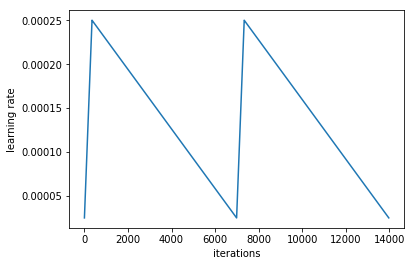

In [34]:
learner.sched.plot_lr()

In [35]:
learner.fit(lrs/16,1,cycle_len=8,use_clr=(5,20))

epoch      trn_loss   val_loss   acc        
    0      0.588394   0.676836   0.969055  
    1      0.574403   0.662641   0.96925   
    2      0.571435   0.675894   0.968974  
    3      0.548223   0.661507   0.969457  
    4      0.540546   0.673877   0.968963  
    5      0.552364   0.662302   0.969238  
    6      0.538366   0.652667   0.970433  
    7      0.535605   0.662207   0.969618  


[0.6622071362830497, 0.9696176188639539]

In [36]:
learner.save('ResNet34_3br_1ch_256_1')

In [37]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

preds,y = learner.TTA(n_aug=32)
preds = np.stack(preds, axis=-1)
preds = sigmoid_np(preds)
pred = preds.max(axis=-1)

In [38]:
def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [39]:
th = fit_val(pred,y)
th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

Thresholds:  [0.48117 0.60564 0.62186 0.53789 0.73787 0.56369 0.47381 0.58197 0.86963 0.57874 0.48917 0.58392 0.55106
 0.58722 0.57403 0.37114 0.63677 0.40668 0.43858 0.52921 0.43971 0.42551 0.48605 0.60588 0.60847 0.55353
 0.47039 0.5    ]
F1 macro:  0.6793087635252091
F1 macro (th = 0.5):  0.6198684776867701
F1 micro:  0.7394643560456873


/home/menoua/.conda/envs/tfgpu/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 5800.
  warnings.warn(errors[info][0], RuntimeWarning)
/home/menoua/.conda/envs/tfgpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/menoua/.conda/envs/tfgpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/menoua/.conda/envs/tfgpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/menoua/.conda/envs/tfgpu/lib/python3.6/site-

In [30]:
print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > th).mean(axis=0))

Fractions:  [0.4852  0.01898 0.09749 0.04311 0.05888 0.08333 0.03893 0.07497 0.00515 0.00225 0.00257 0.02027 0.01448
 0.01641 0.03636 0.      0.5843  0.00515 0.02896 0.05534 0.02156 0.18822 0.01931 0.1213  0.00579 0.32561
 0.0045  0.00064]
Fractions (true):  [0.41055 0.03732 0.11454 0.04891 0.05985 0.08462 0.03411 0.08591 0.00225 0.00161 0.00129 0.03411 0.01802
 0.01737 0.03861 0.      0.01834 0.00708 0.02799 0.05245 0.00772 0.12773 0.02252 0.10135 0.00901 0.26641
 0.0103  0.     ]


In [40]:
preds_t,y_t = learner.TTA(n_aug=32,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
preds_t = sigmoid_np(preds_t)
pred_t = preds_t.max(axis=-1) #max works better for F1 macro score

In [41]:
def save_pred(pred, th=0.5, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(SAMPLE)
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(learner.data.test_ds.fnames,pred_list))
    pred_list_cor = [pred_dic[id] for id in sample_list]
    df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
    df.to_csv(fname, header=True, index=False)

In [42]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]
# I replaced 0 by 0.01 since there may be a rounding error leading to 0

In [43]:
def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y, wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [44]:
th_t = fit_test(pred_t, lb_prob)
th_t[th_t<0.1] = 0.1
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))

Thresholds:  [0.57237 0.47    0.6787  0.45308 0.54818 0.4846  0.41119 0.54614 0.4145  0.22099 0.17972 0.52027 0.32784
 0.51786 0.59587 0.19732 0.49912 0.49614 0.45672 0.44854 0.35194 0.49379 0.45637 0.62853 0.46967 0.62676
 0.39197 0.14075]
Fractions:  [0.36225 0.04264 0.07443 0.05768 0.07418 0.07264 0.04213 0.07503 0.00957 0.00846 0.00889 0.0429  0.04239
 0.01393 0.04367 0.00778 0.02752 0.01316 0.02735 0.05683 0.00897 0.12494 0.02811 0.07358 0.00991 0.2215
 0.02641 0.00342]
Fractions (th = 0.5):  [0.45232 0.03931 0.17817 0.04341 0.0934  0.06614 0.02538 0.09332 0.00547 0.00094 0.0006  0.04786 0.01846
 0.01495 0.05683 0.      0.02735 0.01273 0.0176  0.04016 0.00265 0.12212 0.02239 0.1422  0.00931 0.4307
 0.0129  0.     ]


In [45]:
save_pred(pred_t, th_t, 'attempt_6_0_f.csv')

In [46]:
save_pred(pred_t, th, 'attempt_6_0_v.csv')
save_pred(pred_t, 0.5, 'attempt_6_0_05.csv')

In [47]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,'attempt_6_0_c.csv')